# OMOP Data Exploration and Analysis with PostgreSQL

This jupyter notebook includes a example for querying and analyzing OMOP(Observational Medical Outcomes Partnership) data stored in a PostgreSQL database. The notebook covers essential steps, from establishing a connection to the database to executing SQL queries, and visualizing key insights.

https://www.ohdsi.org/data-standardization/

### Importing required Libraries

- **psycopg2** For establishing a connection between python and a PostgreSQL database.
- **pandas** For efficient data handling, manipulation nad analysis of data.
- **sqlio** For executing SQL queries and reading the results directly into pandas dataframe.

In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import warnings

warnings.filterwarnings('ignore') #ignoring warning related to sqlio and sql alchemy. Will improve this.

### Database connection and setup

Please change the username password to your OMOP DB.

In [2]:
conn = ps.connect(dbname="ohdsi",
                   user = "ohdsi_admin_user",
                   password = "admin1",
                   host = "omop-db-postgress",
                   port = "5432")

## Initial Analysis - Query Counts from OMOP DB
### Number of Person

In [3]:
df = sqlio.read_sql_query("SELECT COUNT(*) FROM cds_cdm.person", conn)
df.head()

,count
0,130


### Number of Observation

In [4]:
df = sqlio.read_sql_query("SELECT COUNT(*) FROM cds_cdm.observation", conn)
df.head()

,count
0,9040


### Number of Death

In [5]:
df = sqlio.read_sql_query("SELECT COUNT(*) FROM cds_cdm.death", conn)
df.head()

,count
0,30


### Number of Procedure

In [6]:
df = sqlio.read_sql_query("SELECT COUNT(*) FROM cds_cdm.procedure_occurrence", conn)
df.head()

,count
0,9400


### Number of measurements eg: Height, Weight etc.

In [7]:
df = sqlio.read_sql_query("SELECT COUNT(*) FROM cds_cdm.measurement", conn)
df.head()

,count
0,97089


### Describe Height meaurements

In [8]:
df = sqlio.read_sql_query("SELECT * FROM cds_cdm.measurement where measurement_source_concept_id=3036277", conn)
df["value_as_number"].describe()

count    2048.000000
mean      160.541455
std        27.589257
min        51.100000
25%       162.700000
50%       170.000000
75%       175.400000
max       189.300000
Name: value_as_number, dtype: float64

## Procedure specific longitudinal Analysis

### Enter OMOP code for a procedure eg: Mammography for breast cancer
#### Search example
https://athena.ohdsi.org/search-terms/terms?conceptClass=Procedure&page=1&pageSize=15&query=Mammography&boosts 

In [124]:
omop_code = 4324693 #Code for Mammography. Please change this to the code that you are interested in.
df = sqlio.read_sql_query(f"SELECT * FROM cds_cdm.procedure_occurrence where procedure_concept_id={omop_code}", conn)
df.head()

,procedure_occurrence_id,fhir_identifier,fhir_logical_id,modifier_concept_id,modifier_source_value,person_id,procedure_concept_id,procedure_date,procedure_datetime,procedure_source_concept_id,procedure_source_value,procedure_type_concept_id,provider_id,quantity,visit_detail_id,visit_occurrence_id
0,19543,None,pro-171732,None,None,400,4324693,2021-02-09,2021-02-09 03:54:27,4324693,71651007,32817,None,None,None,None
1,19524,None,pro-171987,None,None,400,4324693,2023-01-24,2023-01-24 13:14:57,4324693,71651007,32817,None,None,None,None
2,19683,None,pro-171665,None,None,400,4324693,2020-02-26,2020-02-26 01:15:04,4324693,71651007,32817,None,None,None,None
3,19705,None,pro-171917,None,None,400,4324693,2022-02-20,2022-02-20 13:25:10,4324693,71651007,32817,None,None,None,None
4,20704,None,pro-193832,None,None,413,4324693,2016-04-14,2016-04-14 03:09:15,4324693,71651007,32817,None,None,None,None


In [120]:
df = sqlio.read_sql_query(f"SELECT person_id, COUNT(person_id) AS count FROM cds_cdm.procedure_occurrence where procedure_concept_id={omop_code} GROUP BY person_id", conn)


#### Generate Kernel Density Estimate plot using Gaussian kernels.
In statistics, kernel density estimation (KDE) is a non-parametric way
to estimate the probability density function (PDF) of a random variable.
This function uses Gaussian kernels and includes automatic bandwidth determination.
The more this kernel is shifted to the right, the more longitudinal data we have.
With this we can figure out if this particular disease vertical has longitudinal data


<Axes: title={'center': 'KDE of count of visit per unique patient'}, ylabel='Density'>

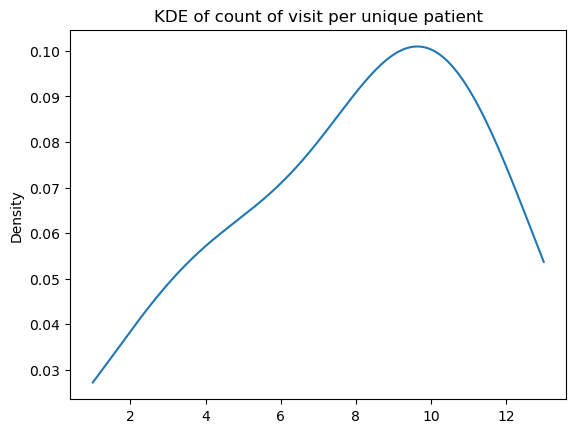

In [121]:
df['count'].plot(title="KDE of count of visit per unique patient",kind='kde') #Kernel Density estimate

<Axes: title={'center': 'Number of visit per unique patient Histogram'}, ylabel='Frequency'>

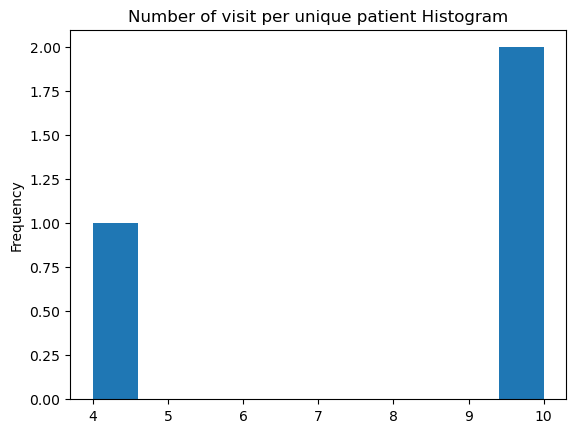

In [122]:
df['count'].plot(kind='hist',title="Number of visit per unique patient Histogram") #Histogram